In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

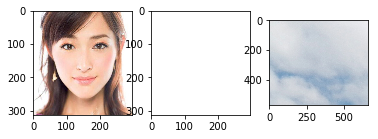

In [18]:
img_target = cv2.cvtColor(cv2.imread('./ignore/building2.jpg'), cv2.COLOR_BGR2RGB).astype(np.uint8)
img_source = cv2.cvtColor(cv2.imread('./ignore/face.JPG'), cv2.COLOR_BGR2RGB).astype(np.uint8)
img_mask = np.full(img_source.shape, 255).astype(np.uint8)

plt.subplot(1, 3, 1)
plt.imshow(img_source)

plt.subplot(1, 3, 2)
plt.imshow(img_mask)

plt.subplot(1, 3, 3)
plt.imshow(img_target)

plt.show()

In [31]:
import scipy.sparse
import PIL.Image
import pyamg

def blend(img_target, img_source, img_mask, offset=(0, 0)):
    # compute regions to be blended
    region_source = (
        max(-offset[0], 0),
        max(-offset[1], 0),
        min(img_target.shape[0] - offset[0], img_source.shape[0]),
        min(img_target.shape[1] - offset[1], img_source.shape[1]))
    region_target = (
        max(offset[0], 0),
        max(offset[1], 0),
        min(img_target.shape[0], img_source.shape[0] + offset[0]),
        min(img_target.shape[1], img_source.shape[1] + offset[1]))
    region_size = (region_source[2] - region_source[0], region_source[3] - region_source[1])

    # clip and normalize mask image
    img_mask = img_mask[region_source[0]:region_source[2], region_source[1]:region_source[3]]
    img_mask[img_mask == 0] = False
    img_mask[img_mask != False] = True

    # create coefficient matrix
    A = scipy.sparse.identity(np.prod(region_size), format='lil')
    for y in range(region_size[0]):
        for x in range(region_size[1]):
            if img_mask[y, x].any():
                index = x + y * region_size[1]
                A[index, index] = 4
                if index + 1 < np.prod(region_size):
                    A[index, index + 1] = -1
                if index - 1 >= 0:
                    A[index, index - 1] = -1
                if index + region_size[1] < np.prod(region_size):
                    A[index, index + region_size[1]] = -1
                if index - region_size[1] >= 0:
                    A[index, index - region_size[1]] = -1
    A = A.tocsr()
    w,h,k = img_mask.shape

    # for each layer (ex. RGB)
    for num_layer in range(img_target.shape[2]):
        
        # create poisson matrix for b
        P = pyamg.gallery.poisson((w,h))
        
        # get subimages
        t = img_target[region_target[0]:region_target[2], region_target[1]:region_target[3], num_layer]
        s = img_source[region_source[0]:region_source[2], region_source[1]:region_source[3], num_layer]
        
        #print s.shape
        t = t.flatten()
        s = s.flatten()

        # create b
        #print P.shape, s.shape
        b = P * s
        for y in range(region_size[0]):
            for x in range(region_size[1]):
                if not img_mask[y, x].any():
                    index = x + y * region_size[1]
                    b[index] = t[index]

        # solve Ax = b
        x = pyamg.solve(A, b, verb=False, tol=1e-10)

        # assign x to target image
        x = np.reshape(x, region_size)
        x[x > 255] = 255
        x[x < 0] = 0
        x = np.array(x, img_target.dtype)
        img_target[region_target[0]:region_target[2], region_target[1]:region_target[3], num_layer] = x

    return img_target

In [32]:
img_result = blend(img_target, img_source, img_mask)
plt.imshow(img_result)
plt.show()

TypeError: 'dia_matrix' object has no attribute '__getitem__'